## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [5]:
pip install numpy pandas scipy statsmodels matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [3]:
data = pd.read_csv('/Users/margaritakozlova/Downloads/homework_2/ab_test_inference/ab_test_ensembles.csv')
data.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [9]:
# Размер датасета 
data.shape

(294478, 8)

In [10]:
# Основная информация по датасету, converted - бинарный, остальные - категориальные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [11]:
# Проверка на пропуски - нет пропусков, датасет заполнен
data.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [13]:
data.groupby('group')['converted'].mean()

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

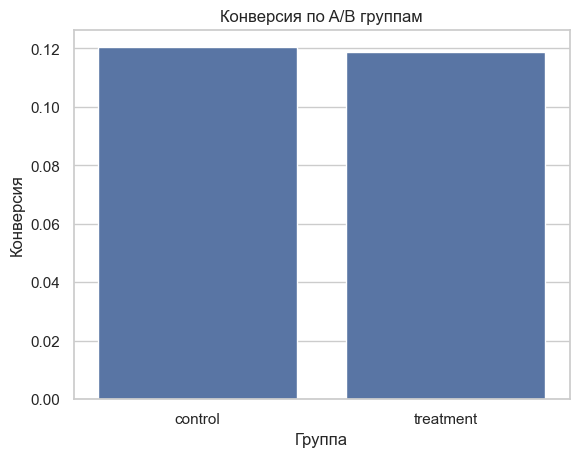

In [15]:
# График напрямую отвечает на вопрос: даёт ли treatment прирост конверсии по сравнению с control
plt.figure()
sns.barplot(
    data=data,
    x='group',
    y='converted',
    estimator='mean',
    errorbar=None
)
plt.title('Конверсия по A/B группам')
plt.xlabel('Группа')
plt.ylabel('Конверсия')
plt.show()

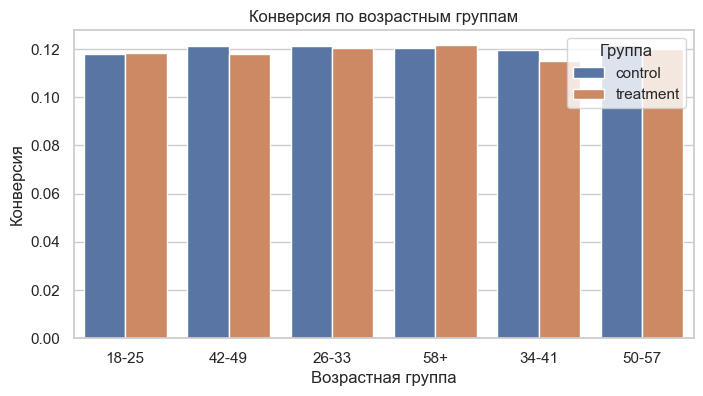

In [16]:
# Видно, в каких возрастных сегментах treatment работает лучше. Эффект treatment неоднороден по возрастным группам
plt.figure(figsize=(8, 4))
sns.barplot(
    data=data,
    x='age_group',
    y='converted',
    hue='group',
    estimator='mean',
    errorbar=None
)
plt.title('Конверсия по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Конверсия')
plt.legend(title='Группа')
plt.show()

In [4]:
data.groupby('user_type')['converted'].mean()

user_type
new_user           0.119154
registered_user    0.120164
Name: converted, dtype: float64

In [5]:
data.groupby('variants')['converted'].mean()

variants
standard               0.120478
svm_ensemble_v_1_22    0.118841
Name: converted, dtype: float64

In [6]:
# Проверим на наличие дубликатов пользователей - нет дубликатов 
session_counts = data['user_id'].value_counts()
users_to_drop = session_counts[session_counts > 1].index
data = data[~data['user_id'].isin(users_to_drop)]

In [7]:
ab_results = data.groupby('group')['converted'].agg(['count', 'sum', 'mean'])
ab_results.columns = ['n', 'converted_sum', 'conversion_rate']
ab_results

,n,converted_sum,conversion_rate
group,,,
control,147202,17723,0.120399
treatment,147276,17514,0.118920


/var/folders/kz/6d9wt1vs22vdyz5v89mgt67c0000gn/T/ipykernel_35164/2783909710.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=data['group'], y=data['converted'], ci=False)


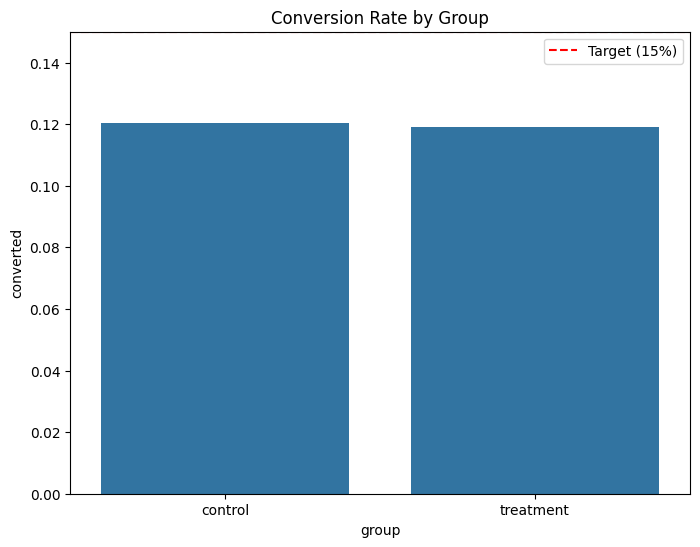

In [8]:
# Есть различия в конверсии между control и treatment
plt.figure(figsize=(8, 6))
sns.barplot(x=data['group'], y=data['converted'], ci=False)
plt.title('Conversion Rate by Group')
plt.ylim(0, 0.15)
plt.axhline(y=0.15, color='r', linestyle='--', label='Target (15%)')
plt.legend()
plt.show()

In [10]:
# Cтатистические тесты
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = data[data['group'] == 'control']['converted']
treatment_results = data[data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control: [{lower_con:.4f}, {upper_con:.4f}]')
print(f'CI 95% for treatment: [{lower_treat:.4f}, {upper_treat:.4f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control: [0.1187, 0.1221]
CI 95% for treatment: [0.1173, 0.1206]


P-value = 0.216
Мы не можем отклонить нулевую гипотезу. Разница с вероятностью 21.6% вызвана случайностью, а не вашими изменениями.
Z-statistic = 1.24
Эксперимент не подтвердил, что тестовый вариант (treatment) работает лучше или хуже, чем контроль. С точки зрения статистики, результаты групп идентичны.

In [33]:
user_type_analysis = data.groupby(['user_type', 'group'])['converted'].mean().unstack()
print(user_type_analysis)

group             control  treatment
user_type                           
new_user         0.120746   0.117557
registered_user  0.120051   0.120277


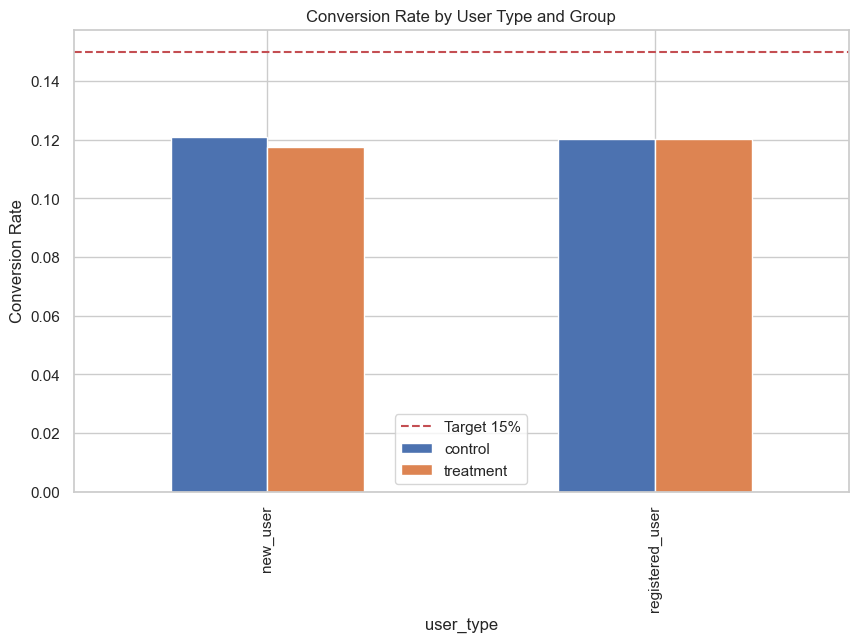

In [38]:
user_type_analysis.plot(kind='bar', figsize=(10, 6))
plt.title('Conversion Rate by User Type and Group')
plt.ylabel('Conversion Rate')
plt.axhline(y=0.15, color='r', linestyle='--', label='Target 15%')
plt.legend()
plt.show()

In [39]:
segments = data.groupby(['user_type', 'group'])['converted'].agg(['count', 'mean']).reset_index()
print(segments)

         user_type      group  count      mean
0         new_user    control  73750  0.120746
1         new_user  treatment  73488  0.117557
2  registered_user    control  73452  0.120051
3  registered_user  treatment  73788  0.120277
